In [1]:
## Importar librerias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [2]:
# Paso 1: Construcción de la lista de archivos
column_names = ['ch_acc_X', 'ch_acc_Y', 'ch_acc_Z','ecg_signal1', 'ecg_signal2','lf_ank_acc_X','lf_ank_acc_Y','lf_ank_acc_Z','lf_ank_gyr_X','lf_ank_gyr_Y','lf_ank_gyr_Z','lf_ank_mag_X','lf_ank_mag_Y','lf_ank_mag_Z','rt_lwr_arm_acc_X','rt_lwr_arm_acc_Y','rt_lwr_arm_acc_Z','rt_lwr_arm_gyr_X','rt_lwr_arm_gyr_Y','rt_lwr_arm_gyr_Z','rt_lwr_arm_mag_X','rt_lwr_arm_mag_Y','rt_lwr_arm_mag_Z','activity']
subjects = ['mHealth_subject1','mHealth_subject2','mHealth_subject3','mHealth_subject4','mHealth_subject5','mHealth_subject6','mHealth_subject7','mHealth_subject8','mHealth_subject9','mHealth_subject_10']
activity_obj = {"1": "Standing still","2": "Sitting and relaxing","3": "Lying down","4": "Walking","5": "Climbing stairs","6": "Waist bends forward","7": "Frontal elevation of arms","8": "Knees bending (crouching)","9": "Cycling","10": "Jogging","11": "Running","12": "Jump front & back"}

# Convert the dictionary to a DataFrame
df_activities = pd.DataFrame(list(activity_obj.items()), columns=['Key', 'Activity'])
#display(df_activities)

# Convert the dictionary to an array (list of tuples)
activities = list(activity_obj.items())
#display(activities)

In [38]:
##### Funciones #####
## Processar datos
def process_subjects(file_paths):
    # Inicializar DataFrame vacío para acumular datos del sujeto
    df_subjects = pd.DataFrame(columns=column_names)
    for subject in subjects:
        for file_path in file_paths:
            if subject in file_path: # Filtrar archivos del sujeto actual
                df_temp = pd.read_csv(file_path, sep="\t", header=None, names=column_names)
                df_subjects = pd.concat([df_subjects, df_temp], ignore_index=True)
    return df_subjects

## Paso 2: Leer y explorar los datos
def generate_firstfive(file_paths):
    df_example = pd.read_csv(file_paths[0], sep="\t", header=None, names=column_names)
    print("Primeras 5 líneas del primer archivo:")
    display(df_example.head())

## Paso 3: Limpieza de datos
def parse_data(df):
    if df.isna().any().any():
        print("DataFrame contains NaN values, dropping values...")
        df.dropna(inplace=True)
        return df
    else:
        print("No NaN values found in dataset")

## Paso 4: Tipos de datos
def generate_datatypes(df):
    # df.dropna
    print("Tipos de datos de cada atributo:")
    display(df.dtypes.to_frame().rename(columns={0: 'Data Types'}))
    total_values = df.shape[0]
    print("Número total de valores en el conjunto de datos:", total_values)

## Paso 5: Resumen estadístico
def generate_statsummary(df):
    print("Resumen estadístico:")
    display(df.describe())

## Paso 6: Distribución de clases
def generate_classdistribution(df):
    print("Distribución de clases")
    display(df.iloc[:, -1].value_counts().to_frame()) # Here we're using ':' to select all rows or essentially ignore all rows except ',-1' which is the last column

    class_labels = np.unique(df_subjects['activity'])

    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=df_subjects['activity'])
    print("Distribución de clases balanceado")
    display(dict(zip(class_labels, class_weights)))

## Paso 7: Correlación entre atributos
def generate_correlation(df):
    print("Correlación entre atributos")
    display(df.corr(method='pearson',numeric_only=True))

## Paso 8: Histograma de atributos
def generate_histogram(df):
    plt.figure()
    df.hist(bins=50, figsize=(12,12), xlabelsize=5, ylabelsize=5)
    plt.title("Histograma")
    plt.show()

## Paso 9: Gráfica de densidad
def generate_densitygraph(df):
    df.plot(kind='density', subplots=True, layout=(9,5), sharex=False, figsize=(20,15))
    plt.title("Gráfica de densidad")
    plt.show()

## Paso 10: Gráfica de cajas y bigotes
def generate_boxplot(df):
    df.plot(kind='box', subplots=True, layout=(9,5), sharex=False, sharey=False, figsize=(20,15))
    plt.title("Gráfica de cajas y bigotes")
    plt.show()

## Paso 11: Matriz de correlación
def generate_corrmatrix(df):
    # corr = df.corr()
    corr = df.corr(method='pearson',numeric_only=True)
    sns.heatmap(corr, annot=False, cmap='tab20')
    plt.title("Matriz de correlación")
    plt.show()

## Paso 12: Matriz de dispersión
def generate_scatterplot(df):
    pd.plotting.scatter_matrix(df, figsize=(20, 15))
    plt.title("Matriz de dispersión")
    plt.show()

## Paso 13: Escalado y normalización
def transform_data(df):
    # Appling normalization only to Electrocardiogram readings to scale the values to a fixed range
    columns_for_normalization = ['ecg_signal1', 'ecg_signal2']
    scaler_normalization = MinMaxScaler()
    df_transformedset = df.copy()
    df_transformedset[columns_for_normalization] = scaler_normalization.fit_transform(df_transformedset[columns_for_normalization])

    # Apply standardization to Accelerometer, Gyroscope and Magnometer data, this is so that we can
    # center the data around the mean and scale it by the standard deviation for consistency across
    # different axes and sensors.
    columns_for_standardization = ['ch_acc_X', 'ch_acc_Y', 'ch_acc_Z','lf_ank_acc_X', 'lf_ank_acc_Y', 'lf_ank_acc_Z','lf_ank_gyr_X', 'lf_ank_gyr_Y', 'lf_ank_gyr_Z','lf_ank_mag_X', 'lf_ank_mag_Y', 'lf_ank_mag_Z','rt_lwr_arm_acc_X','rt_lwr_arm_acc_Y','rt_lwr_arm_acc_Z','rt_lwr_arm_gyr_X','rt_lwr_arm_gyr_Y','rt_lwr_arm_gyr_Z','rt_lwr_arm_mag_X','rt_lwr_arm_mag_Y','rt_lwr_arm_mag_Z']
    scaler_standardization = StandardScaler()
    df_transformedset[columns_for_standardization] = scaler_standardization.fit_transform(df_transformedset[columns_for_standardization])
    return df_transformedset

## Extract a sample set
def extract_stratifiedsample(df):
    # Identify unique activities in the dataset
    unique_activities = df['activity'].unique()

    # Calculate proportions of observations for each activity
    proportions = df['activity'].value_counts(normalize=True)

    # Specify target sample size for each activity (adjust as needed)
    desired_sample_size = 1200 # For testing purposes, we're extracting a sample of about 10% of the set examples
    target_sample_sizes = {activity: int(proportions[activity] * desired_sample_size) for activity in unique_activities}
    # print(f'target_sample_sizes {target_sample_sizes}')

    # Initialize an empty dataframe to store the stratified sample
    stratified_sample = pd.DataFrame()

    # Sample from each activity stratum
    for activity, target_size in target_sample_sizes.items():
        # Select observations corresponding to the current activity
        activity_data = df[df['activity'] == activity]
        # Perform stratified sampling for the current activity
        activity_sample = activity_data.sample(n=target_size, replace=False, random_state=42)
        # Append the sampled observations to the stratified sample dataframe
        stratified_sample = pd.concat([stratified_sample, activity_sample])

    # Display information about the stratified sample
    # print("Stratified Sample Size:", len(stratified_sample))
    # print("Stratified Sample Distribution:")
    # print(stratified_sample['activity'].value_counts(normalize=True))

    # We could also split the stratified sample into train and test sets so that we can test our models performance
    # but given the set size, its more convenient to extract a smaller sample size
    # train_set, test_set = train_test_split(stratified_sample, test_size=0.2, random_state=42)
    return stratified_sample

def generate_comparison(term, df_original, df_transformed):

    do_corr = "correlation"
    do_hist = "histogram"
    do_boxp = "boxplot"
    # do_dens = "density"
    # do_scat = "scatterplot"
    actionlist = [do_corr,do_hist,do_boxp]
    if (term) in actionlist:
      if term == do_corr:
        # Calculate correlation matrices
        corr_original = df_original.corr()
        corr_transformed = df_transformed.corr()

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Plot heatmap for original dataframe
        sns.heatmap(corr_original, ax=axes[0], cmap='tab20', fmt=".2f")
        axes[0].set_title('Matriz Original')

        # Plot heatmap for transformed dataframe
        sns.heatmap(corr_transformed, ax=axes[1], cmap='tab20', fmt=".2f")
        axes[1].set_title('Matriz Transformada')

        plt.tight_layout()
        plt.show()

      elif term == do_hist:
        # fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        # Plot histograms for the original dataframe
        plt.figure()
        df_original.hist(bins=50, figsize=(12,12), xlabelsize=5, ylabelsize=5)
        plt.title('Histograma - Original ')
        plt.show()

        # Plot histograms for the transformed dataframe
        plt.figure()
        df_transformed.hist(bins=50, figsize=(12,12), xlabelsize=5, ylabelsize=5)
        plt.title('Histograma - Transformada')
        plt.show()

      elif term == do_boxp:
        # fig, axes = plt.subplots(2, 1, figsize=(20, 15))
        # Plot boxplot for the original dataframe
        df_original.plot(kind='box', subplots=True, layout=(9, 5), sharex=False, sharey=False, figsize=(20,15))
        plt.title('Caja y Bigotes - Original')
        plt.show()

        # Plot boxplot for the transformed dataframe
        df_transformed.plot(kind='box', subplots=True, layout=(9, 5), sharex=False, sharey=False, figsize=(20,15))
        plt.title('Caja y Bigotes - Transformada')
        plt.show()

    # if (term) in do_dens:
    # if (term) in do_scat:




In [4]:
## Ejecución
# directory_path = "datasets/mhealth"
directory_path = "/content/drive/MyDrive/RAHBFDP-2024_Proyecto/Datasets/mhealth"
file_paths = []

for subject in subjects:
        file_name = f'{subject}.log'
        file_path = os.path.join(directory_path, file_name)
        file_paths.append(file_path)

# Leemos
df_subjects = process_subjects(file_paths)

In [ ]:
# Paso 2: Leer y explorar los datos
generate_firstfive(file_paths)

In [ ]:
# Paso 3: Limpieza de datos
parse_data(df_subjects)

In [14]:
# Paso 4: Tipos de datos
generate_datatypes(df_subjects)

Tipos de datos de cada atributo:


,Data Types
ch_acc_X,float64
ch_acc_Y,float64
ch_acc_Z,float64
ecg_signal1,float64
ecg_signal2,float64
lf_ank_acc_X,float64
lf_ank_acc_Y,float64
lf_ank_acc_Z,float64
lf_ank_gyr_X,float64
lf_ank_gyr_Y,float64


Número total de valores en el conjunto de datos: 1215745


In [11]:
# Paso 5: Resumen estadístico
generate_statsummary(df_subjects)

Resumen estadístico:


,ch_acc_X,ch_acc_Y,ch_acc_Z,ecg_signal1,ecg_signal2,lf_ank_acc_X,lf_ank_acc_Y,lf_ank_acc_Z,lf_ank_gyr_X,lf_ank_gyr_Y,...,lf_ank_mag_Z,rt_lwr_arm_acc_X,rt_lwr_arm_acc_Y,rt_lwr_arm_acc_Z,rt_lwr_arm_gyr_X,rt_lwr_arm_gyr_Y,rt_lwr_arm_gyr_Z,rt_lwr_arm_mag_X,rt_lwr_arm_mag_Y,rt_lwr_arm_mag_Z
count,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,...,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06
mean,-8.522361e+00,-2.140013e-01,-1.055950e+00,-5.122403e-03,-4.506434e-03,1.494200e+00,-9.692878e+00,-9.548056e-01,-1.598951e-03,-6.166318e-01,...,-8.566162e-01,-3.713413e+00,-5.805526e+00,2.393880e+00,-2.761061e-01,-4.664340e-01,2.666335e-01,1.702138e-01,7.144626e-01,-3.668126e-01
std,4.075293e+00,2.138954e+00,3.574163e+00,7.465971e-01,7.270395e-01,3.826485e+00,4.171303e+00,5.461803e+00,4.912172e-01,3.546406e-01,...,1.768224e+01,4.763586e+00,5.757639e+00,3.876503e+00,5.276888e-01,5.555510e-01,5.643804e-01,2.667617e+01,3.344453e+01,6.955069e+01
min,-2.243800e+01,-2.018800e+01,-1.840100e+01,-8.619600e+00,-8.619600e+00,-2.214600e+01,-1.961900e+01,-1.937300e+01,-2.146600e+00,-7.789900e+00,...,-2.823900e+02,-2.236100e+01,-1.897200e+01,-1.823900e+01,-8.339200e+00,-3.570800e+00,-2.689700e+00,-3.190300e+02,-3.639000e+02,-7.175500e+02
25%,-9.804000e+00,-1.272900e+00,-2.867300e+00,-2.344300e-01,-1.883800e-01,1.413100e-01,-1.020100e+01,-2.649400e+00,-4.359900e-01,-8.180100e-01,...,-2.833100e+00,-6.076000e+00,-9.404200e+00,1.296500e-01,-7.058800e-01,-8.973300e-01,-2.370700e-01,-6.191900e+00,-9.519500e+00,-1.423800e+01
50%,-9.311400e+00,-3.538100e-01,-8.702000e-01,-7.116700e-02,-4.186300e-02,1.308900e+00,-9.670300e+00,-1.645600e-02,-1.484200e-02,-7.073200e-01,...,-4.349900e-01,-2.977600e+00,-7.461500e+00,1.928100e+00,-3.549000e-01,-6.345000e-01,3.017200e-01,3.626200e-01,3.521700e-01,-6.729600e-01
75%,-7.637100e+00,7.097800e-01,7.259100e-01,1.590800e-01,1.507100e-01,2.575800e+00,-9.042200e+00,1.301300e+00,4.489800e-01,-5.403400e-01,...,1.976900e+00,-1.193700e+00,-2.533900e+00,4.914700e+00,9.607800e-02,-1.067800e-01,7.780200e-01,6.792300e+00,1.007600e+01,1.318600e+01
max,1.909400e+01,2.092700e+01,2.619600e+01,8.514900e+00,8.519100e+00,2.005400e+01,2.116100e+01,2.501500e+01,6.048400e+01,2.011300e+00,...,2.725600e+02,1.986400e+01,2.219100e+01,2.574100e+01,3.319600e+00,1.556500e+00,2.750000e+00,2.511500e+02,3.377600e+02,6.571800e+02


In [ ]:
# Paso 6: Distribución de clases
generate_classdistribution(df_subjects)

In [ ]:
# Paso 7: Correlación entre atributos
generate_correlation(df_subjects)

In [ ]:
# Paso 8: Histograma de atributos
generate_histogram(df_subjects)

In [ ]:
# Paso 9: Gráfica de densidad
generate_densitygraph(df_subjects)

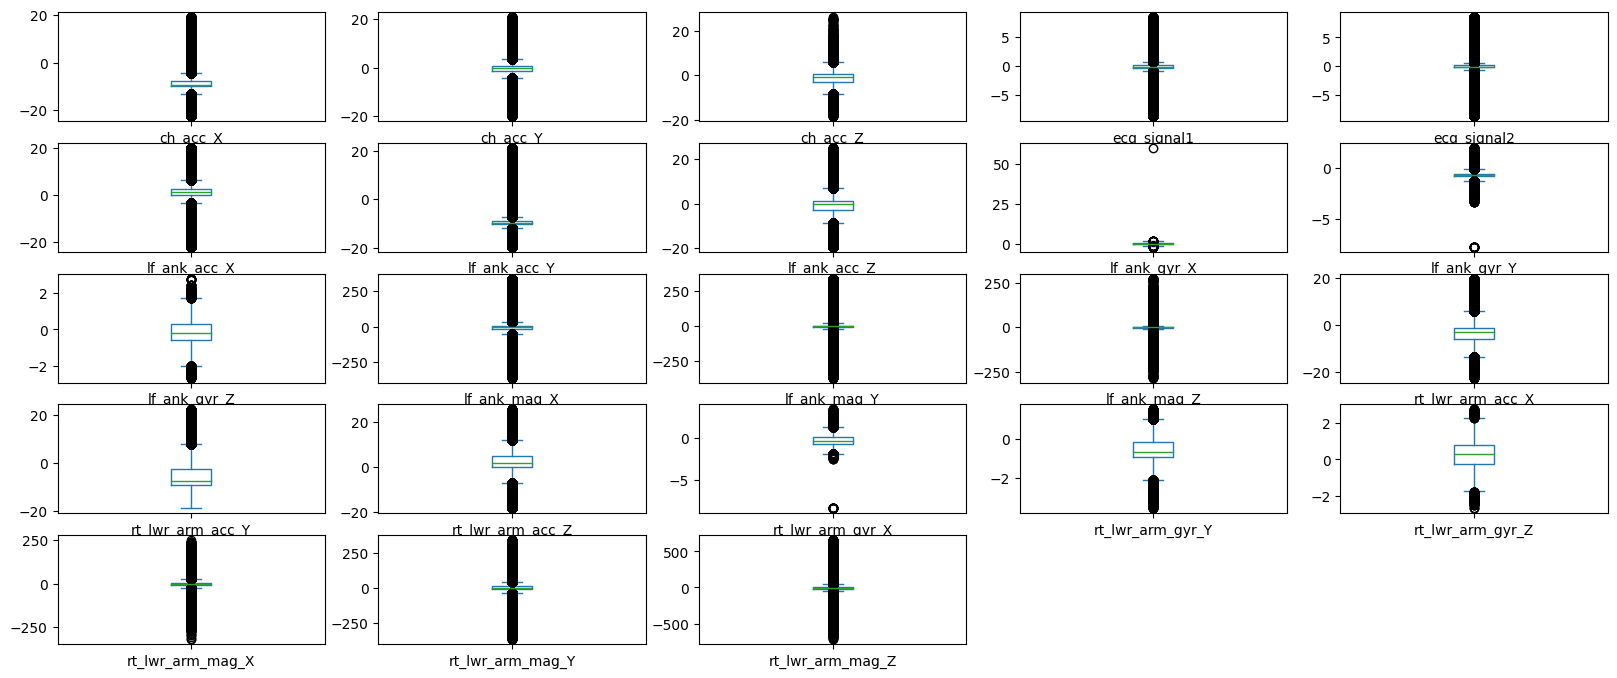

In [32]:
# Paso 10: Gráfica de cajas y bigotes
generate_boxplot(df_subjects)

In [ ]:
# Paso 11: Matriz de correlación
generate_corrmatrix(df_subjects)

In [ ]:
# Paso 12: Matriz de dispersión
generate_scatterplot(df_subjects)

In [ ]:
# Paso 13: Escalado y normalización
df_newsubjects = transform_data(df_subjects)
display(df_newsubjects)

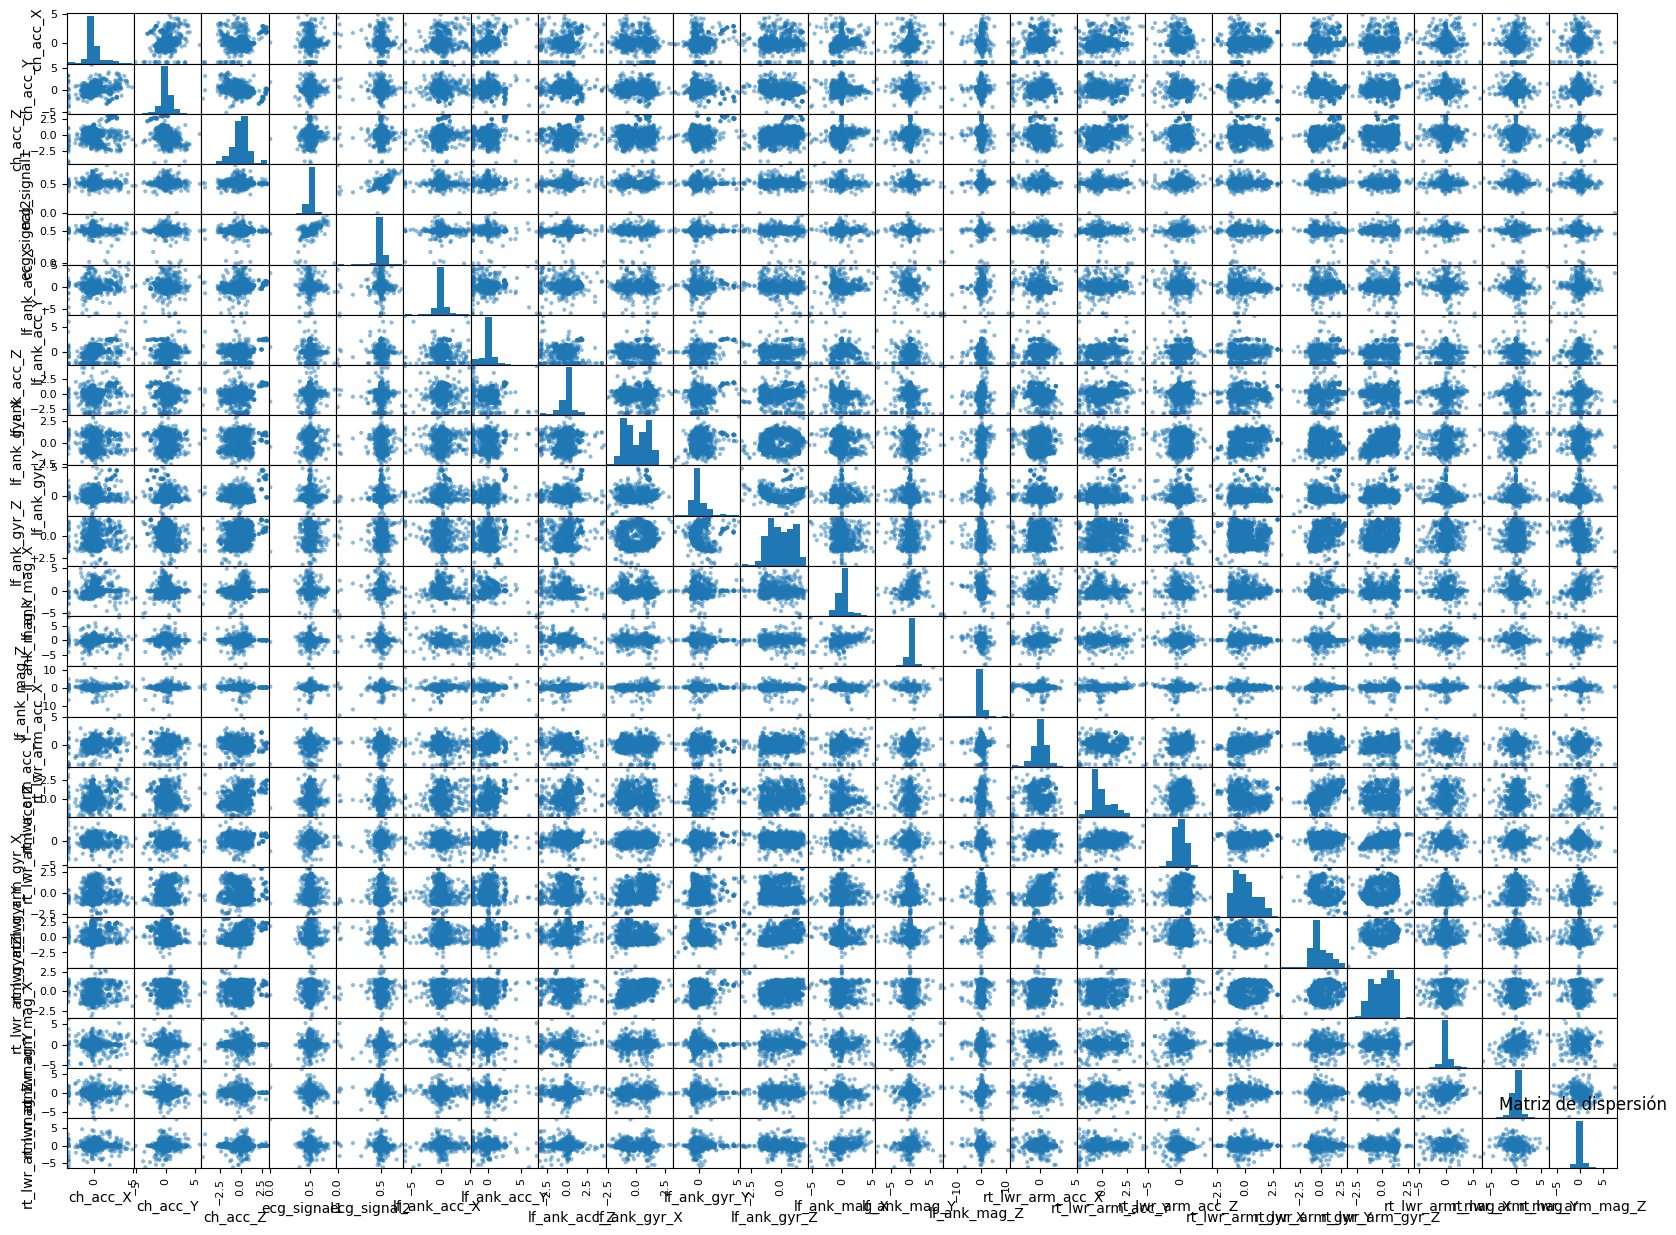

In [39]:
# Extract sample
#sampleset_originalset = extract_stratifiedsample(df_subjects)
#display("Muestro del set original",sampleset_originalset)

sampleset_transformedset = extract_stratifiedsample(df_newsubjects)
#display("Muestro del set transformado",sampleset_transformedset)
generate_scatterplot(sampleset_transformedset)

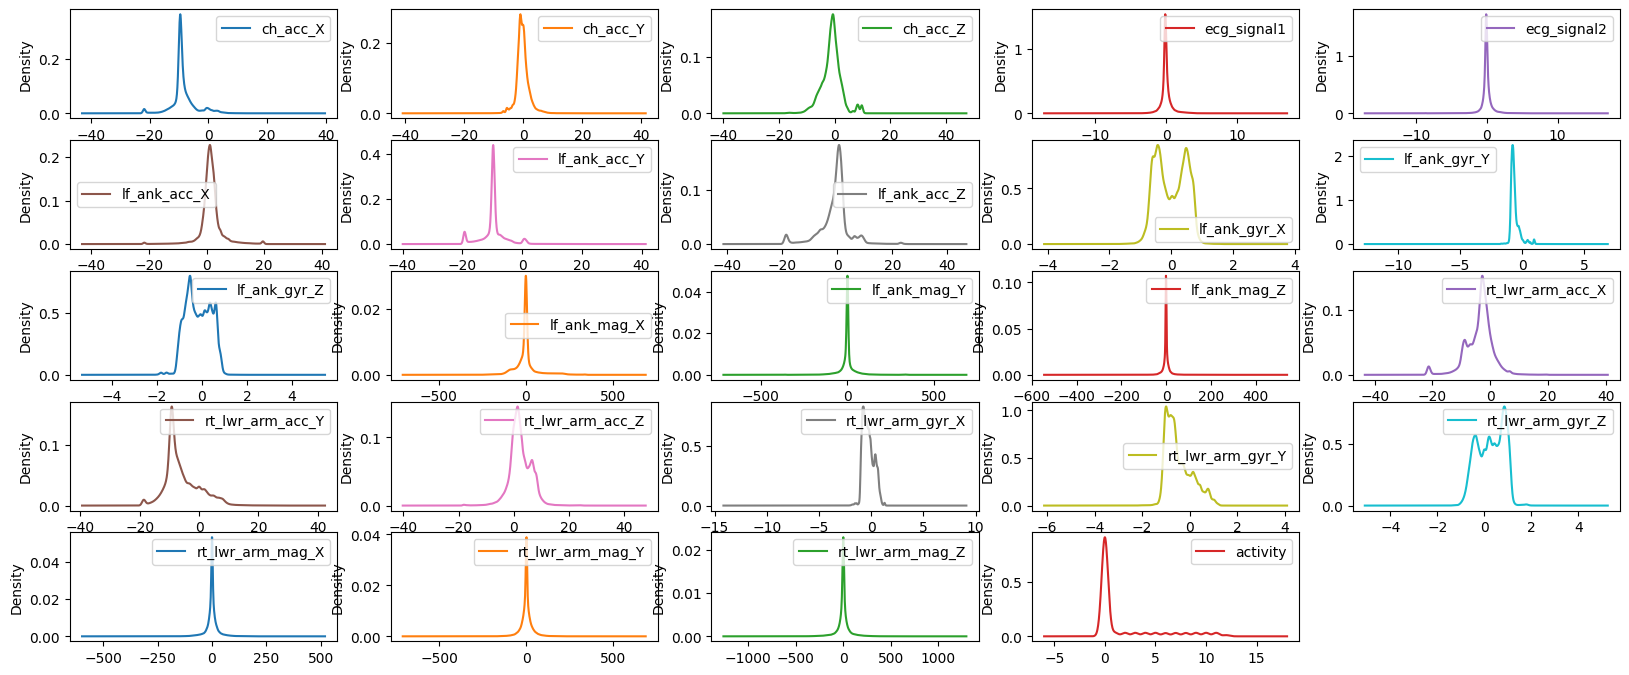

In [30]:
# generate_comparison("correlation",df_subjects,df_newsubjects)
generate_densitygraph(sampleset_originalset)
# generate_densitygraph(sampleset_transformedset)

In [34]:
# Generate new statistical summary
print("Muestro del set original")
generate_statsummary(sampleset_originalset)
print("Muestro del set transformado")
generate_statsummary(sampleset_transformedset)
generate_statsummary(df_newsubjects)

Muestro del set original
Resumen estadístico:


,ch_acc_X,ch_acc_Y,ch_acc_Z,ecg_signal1,ecg_signal2,lf_ank_acc_X,lf_ank_acc_Y,lf_ank_acc_Z,lf_ank_gyr_X,lf_ank_gyr_Y,...,lf_ank_mag_Z,rt_lwr_arm_acc_X,rt_lwr_arm_acc_Y,rt_lwr_arm_acc_Z,rt_lwr_arm_gyr_X,rt_lwr_arm_gyr_Y,rt_lwr_arm_gyr_Z,rt_lwr_arm_mag_X,rt_lwr_arm_mag_Y,rt_lwr_arm_mag_Z
count,119994.00000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,...,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000
mean,-8.52835,-0.212066,-1.050708,-0.002407,-0.002961,1.493150,-9.678835,-0.943963,-0.000820,-0.615727,...,-0.827857,-3.725979,-5.815510,2.382199,-0.276651,-0.468336,0.266938,0.168585,0.611015,-0.348225
std,4.07746,2.142143,3.557290,0.743477,0.727199,3.814673,4.184045,5.426588,0.488537,0.354352,...,17.585855,4.756852,5.771148,3.874489,0.528263,0.555042,0.564033,26.779998,33.504668,69.754059
min,-22.29200,-20.188000,-18.068000,-8.619600,-8.619600,-22.146000,-19.609000,-19.364000,-2.146600,-7.789900,...,-274.170000,-22.361000,-18.972000,-18.230000,-8.339200,-3.570800,-2.504300,-317.930000,-361.060000,-621.970000
25%,-9.80850,-1.270175,-2.841775,-0.234430,-0.188380,0.147700,-10.191000,-2.626400,-0.437850,-0.816140,...,-2.818675,-6.084700,-9.417800,0.127230,-0.705880,-0.899380,-0.234910,-6.081400,-9.655375,-14.319750
50%,-9.32100,-0.351255,-0.866995,-0.071167,-0.041863,1.310950,-9.670600,-0.008941,-0.012987,-0.707320,...,-0.433310,-2.978600,-7.490400,1.923250,-0.354900,-0.634500,0.299570,0.362620,0.350320,-0.675435
75%,-7.64910,0.713448,0.722558,0.163270,0.150710,2.580175,-9.049825,1.303375,0.450830,-0.538460,...,2.016050,-1.201000,-2.564575,4.897400,0.092157,-0.110880,0.778020,6.877275,10.015750,13.301500
max,19.07800,20.905000,25.534000,8.502400,8.502400,20.044000,21.059000,24.843000,1.786600,2.003800,...,269.300000,19.692000,21.977000,25.724000,3.290200,1.540000,2.665900,240.440000,336.220000,655.520000


Muestro del set transformado
Resumen estadístico:


,ch_acc_X,ch_acc_Y,ch_acc_Z,ecg_signal1,ecg_signal2,lf_ank_acc_X,lf_ank_acc_Y,lf_ank_acc_Z,lf_ank_gyr_X,lf_ank_gyr_Y,...,lf_ank_mag_Z,rt_lwr_arm_acc_X,rt_lwr_arm_acc_Y,rt_lwr_arm_acc_Z,rt_lwr_arm_gyr_X,rt_lwr_arm_gyr_Y,rt_lwr_arm_gyr_Z,rt_lwr_arm_mag_X,rt_lwr_arm_mag_Y,rt_lwr_arm_mag_Z
count,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,...,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000,119994.000000
mean,-0.001470,0.000905,0.001467,0.502915,0.502759,-0.000274,0.003367,0.001985,0.001586,0.002550,...,0.001626,-0.002638,-0.001734,-0.003013,-0.001032,-0.003423,0.000540,-0.000061,-0.003093,0.000267
std,1.000532,1.001491,0.995280,0.043391,0.042430,0.996913,1.003055,0.993553,0.994543,0.999186,...,0.994550,0.998587,1.002347,0.999481,1.001089,0.999084,0.999385,1.003893,1.001798,1.002924
min,-3.378811,-9.338210,-4.759732,0.000000,0.000000,-6.178048,-2.377225,-3.370536,-4.366707,-20.226875,...,-15.456954,-3.914612,-2.286784,-5.320230,-15.280023,-5.587907,-4.909693,-11.924514,-10.817153,-8.937416
25%,-0.315594,-0.493781,-0.499649,0.489373,0.491940,-0.351890,-0.119416,-0.306052,-0.888102,-0.562565,...,-0.110962,-0.497795,-0.627388,-0.584715,-0.814446,-0.779309,-0.888663,-0.234352,-0.310061,-0.200615
50%,-0.195971,-0.064169,0.052867,0.498902,0.500489,-0.047890,0.005341,0.173178,-0.023183,-0.255719,...,0.023940,0.154256,-0.292633,-0.121406,-0.149319,-0.302521,0.058359,0.007213,-0.010888,-0.004437
75%,0.214282,0.433599,0.497601,0.512584,0.511726,0.283805,0.154161,0.413450,0.921037,0.220425,...,0.162461,0.527421,0.562896,0.645819,0.697880,0.640003,0.906103,0.251425,0.278111,0.196523
max,6.772611,9.873520,7.439493,0.999270,0.999026,4.847740,7.372251,4.723315,3.640344,7.388982,...,15.278426,4.913404,4.825335,6.018344,6.758354,3.611612,4.251153,9.006911,10.031705,9.430346


Resumen estadístico:


,ch_acc_X,ch_acc_Y,ch_acc_Z,ecg_signal1,ecg_signal2,lf_ank_acc_X,lf_ank_acc_Y,lf_ank_acc_Z,lf_ank_gyr_X,lf_ank_gyr_Y,...,lf_ank_mag_Z,rt_lwr_arm_acc_X,rt_lwr_arm_acc_Y,rt_lwr_arm_acc_Z,rt_lwr_arm_gyr_X,rt_lwr_arm_gyr_Y,rt_lwr_arm_gyr_Z,rt_lwr_arm_mag_X,rt_lwr_arm_mag_Y,rt_lwr_arm_mag_Z
count,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,...,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06
mean,8.576460e-16,-1.776729e-18,-9.631744e-17,5.027563e-01,5.026690e-01,-1.953467e-16,-2.002094e-16,-3.558134e-17,3.684376e-17,1.885203e-16,...,1.014606e-17,3.377656e-16,-1.763638e-16,-4.881330e-17,2.339672e-16,3.138265e-16,-1.911387e-16,-4.161287e-18,1.611914e-17,-3.039142e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,4.357274e-02,4.242092e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.414637e+00,-9.338210e+00,-4.852900e+00,0.000000e+00,0.000000e+00,-6.178048e+00,-2.379622e+00,-3.372183e+00,-4.366707e+00,-2.022688e+01,...,-1.592183e+01,-3.914612e+00,-2.286784e+00,-5.322552e+00,-1.528002e+01,-5.587907e+00,-5.238195e+00,-1.196575e+01,-1.090207e+01,-1.031167e+01
25%,-3.144901e-01,-4.950545e-01,-5.067903e-01,4.893735e-01,4.919405e-01,-3.535596e-01,-1.218137e-01,-3.102629e-01,-8.843159e-01,-5.678377e-01,...,-1.117780e-01,-4.959683e-01,-6.250262e-01,-5.840912e-01,-8.144461e-01,-7.756194e-01,-8.924897e-01,-2.384944e-01,-3.059982e-01,-1.994400e-01
50%,-1.936153e-01,-6.536311e-02,5.197011e-02,4.989018e-01,5.004894e-01,-4.842565e-02,5.412814e-03,1.718022e-01,-2.695967e-02,-2.557188e-01,...,2.384463e-02,1.544663e-01,-2.876134e-01,-1.201548e-01,-1.493190e-01,-3.025214e-01,6.216826e-02,7.212667e-03,-1.083265e-02,-4.401790e-03
75%,2.172265e-01,4.318847e-01,4.985392e-01,5.123394e-01,5.117255e-01,2.826616e-01,1.559893e-01,4.130699e-01,9.172706e-01,2.151243e-01,...,1.602466e-01,5.289532e-01,5.682238e-01,6.502821e-01,7.053101e-01,6.473828e-01,9.061030e-01,2.482399e-01,2.799125e-01,1.948624e-01
max,6.776537e+00,9.883805e+00,7.624711e+00,1.000000e+00,1.000000e+00,4.850354e+00,7.396703e+00,4.754806e+00,1.231342e+02,7.410130e+00,...,1.546279e+01,4.949511e+00,4.862503e+00,6.022729e+00,6.814068e+00,3.641312e+00,4.400166e+00,9.408394e+00,1.007775e+01,9.454213e+00


In [ ]:
grouped_og = sampleset_originalset.groupby('activity')

# Apply the describe() function to each group and concatenate the results
summary_by_class_og = grouped_og.describe()

# Display the summary statistics for each class
display(summary_by_class_og)

grouped = sampleset_transformedset.groupby('activity')

# Apply the describe() function to each group and concatenate the results
summary_by_class = grouped.describe()

# Display the summary statistics for each class
display(summary_by_class)

In [ ]:
# generate_histogram(sampleset_transformedset)
# Group by activity
grouped = sampleset_transformedset.groupby('activity')
# display(grouped)

# Convert the DataFrameGroupBy object to a dictionary
group_dict = dict(list(grouped))

# Get the activity at position 2
activity_at_position = list(group_dict.keys())[4]  # Assuming keys are in the same order as positions

# Get the DataFrame for the specific activity
df_specific_activity = group_dict[activity_at_position]
# display(df_specific_activity)
# Apply the describe() function to each group and concatenate the results
# generate_histogram(grouped)
# generate_histogram(df_specific_activity)

In [ ]:
generate_histogram(df_subjects)